# Conclusions
* There are only 16 variables that might be used
* Univariate relation with target almost not visible for all features
* It is not needed at this stage to use feature selection and narrow down number of features.
* RECOMMENDATION: find more features describing customers

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.feature_selection import VarianceThreshold
import numpy as np
from plotnine import *

pd.options.display.max_rows = 40
pd.options.display.max_columns = 999999

In [2]:
import os
os.chdir("..")

In [3]:
from src.visualization.udfs_visualization import plot_boxplot_by_target, plot_share_of_categorical_vars_by_target
from src.data.udfs_data_prep import compute_counts_and_share, compute_variation_coef 

# Data load

In [4]:
df_merged = pd.read_pickle('data/processed/df_application_record_classified_raw.pickle')

# Feature engineerging

In [5]:
df_merged.occupation_type = df_merged.occupation_type.fillna("Unknown")
df_merged['amt_income_per_person'] = df_merged['amt_income_total'] / df_merged['cnt_fam_members']
df_merged['age'] = -1 * df_merged['days_birth'] / 365
df_merged['job_tenure'] = -1 * df_merged['days_employed'] / 365
df_merged['job_tenure'] = np.where(df_merged["days_employed"] > 0, -1, df_merged['job_tenure'])
df_merged['flag_employed'] = np.where(df_merged["days_employed"] > 0, 0, 1)
df_merged['code_gender'] = np.where(df_merged['code_gender'] == 'M', 1, 0)
df_merged['flag_own_car'] = np.where(df_merged['flag_own_car'] =='Y', 1, 0)
df_merged['flag_own_realty'] = np.where(df_merged['flag_own_realty'] =='Y', 1, 0)
df_merged['single_adult'] = np.where(
    (df_merged['name_family_status'] =='Married') | (df_merged['name_family_status'] == 'Civil marriage'), 0, 1)
df_merged['target'] = np.where((df_merged['customer_status'] =='bad customer') | (df_merged['customer_status'] =='moderate customer'), 1, 0)
df_merged = df_merged.astype({'flag_own_car': int, 
                                'flag_own_realty': int, 
                                'cnt_children': int,
                                'cnt_fam_members': int})

In [6]:
compute_counts_and_share(df_merged, 'target')

,count,share
0,19687,0.984547
1,309,0.015453


In [7]:
# check - there should be no people with flag_work_phone = 1 and flag_employed = 0
df_merged.groupby(['flag_work_phone', 'flag_employed'])['flag_employed'].count().unstack()

flag_employed,0,1
flag_work_phone,,
0,3240.0,12172.0
1,NaN,4584.0


In [8]:
df_merged.groupby(['name_family_status', 'single_adult'])['single_adult'].count().unstack()

single_adult,0,1
name_family_status,,
Civil marriage,1526.0,NaN
Married,14016.0,NaN
Separated,NaN,1181.0
Single / not married,NaN,2517.0
Widow,NaN,756.0


In [9]:
# check age and tenure distribution

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 35'. Pick better value with 'binwidth'.


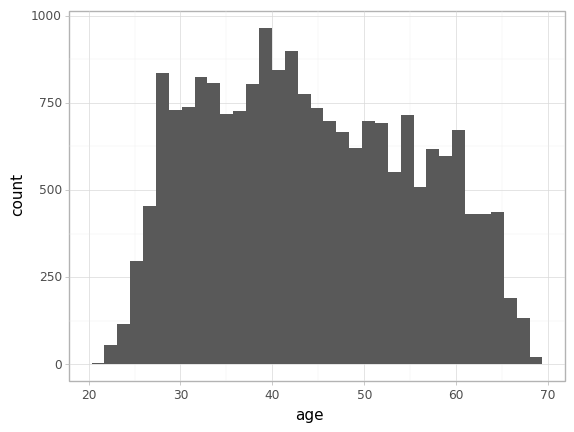

<ggplot: (106959274719)>

In [10]:
(ggplot(df_merged)
 + geom_histogram(aes(x = 'age'))
 + theme_light()
 + xlab('age'))

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 78'. Pick better value with 'binwidth'.


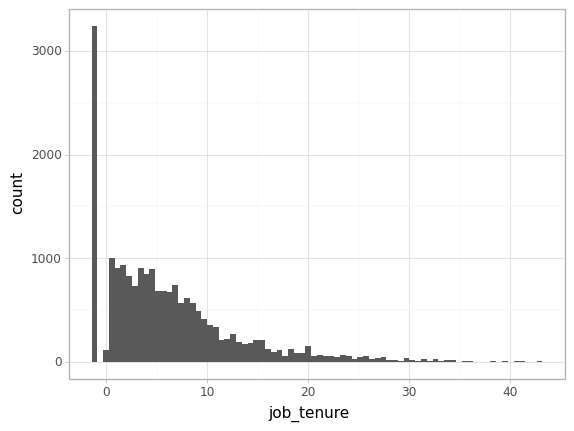

<ggplot: (106959902702)>

In [11]:
(ggplot(df_merged)
 + geom_histogram(aes(x = 'job_tenure'))
 + theme_light()
 + xlab('job_tenure'))

In [12]:
df_merged = df_merged.drop(['flag_mobil', 'flag_work_phone', 'flag_phone', 
                              'flag_email', 'days_birth', 'days_employed',
                              'name_family_status', 'customer_status'], axis = 1)
df_merged

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_housing_type,occupation_type,cnt_fam_members,amt_income_per_person,age,job_tenure,flag_employed,single_adult,target
id,,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,Working,Higher education,Rented apartment,Unknown,2,213750.0,32.890411,12.443836,1,0,0
5008805,1,1,1,0,427500.0,Working,Higher education,Rented apartment,Unknown,2,213750.0,32.890411,12.443836,1,0,0
5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,House / apartment,Security staff,2,56250.0,58.832877,3.106849,1,0,0
5008810,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,Sales staff,1,270000.0,52.356164,8.358904,1,1,0
5008811,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,Sales staff,1,270000.0,52.356164,8.358904,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5149729,1,1,1,0,90000.0,Working,Secondary / secondary special,House / apartment,Unknown,2,45000.0,52.331507,4.715068,1,0,0
5149775,0,1,1,0,130500.0,Working,Secondary / secondary special,House / apartment,Laborers,2,65250.0,44.210959,25.728767,1,0,0
5149834,0,0,1,0,157500.0,Commercial associate,Higher education,House / apartment,Medicine staff,2,78750.0,33.936986,3.630137,1,0,1


In [13]:
df_merged.to_pickle('data/processed/df_application_record_classified_post_feature_eng.pickle')

# Analysis of variance coefficient

In [14]:
num_vars = ['amt_income_total', 'amt_income_per_person', 'age',
            'job_tenure', 'cnt_fam_members', 'cnt_children']

cat_vars = ['code_gender', 'flag_own_car', 'flag_own_realty', 
            'name_income_type', 'name_education_type',
            'name_housing_type', 'occupation_type',
            'flag_employed','single_adult']

In [15]:
variation_coefs = []
sd_coefs = []

for var in num_vars:
    variation_coefs.append(compute_variation_coef(df_merged[var]))
    sd_coefs.append((df_merged[var].var()) ** (0.5))

    
variation_table = pd.DataFrame({'variable' : num_vars,
                               'sd' : sd_coefs,
                               'variation' : variation_coefs})
variation_table

,variable,sd,variation
0,amt_income_total,101914.683357,0.542361
1,amt_income_per_person,72012.025582,0.718657
2,age,11.289478,0.255922
3,job_tenure,6.834543,1.103429
4,cnt_fam_members,0.906382,0.410333
5,cnt_children,0.740378,1.716873


In [16]:
selector = VarianceThreshold(0.9)
selector.fit(df_merged.loc[:, num_vars])

removed_vars = list(set(num_vars) - set(selector.get_feature_names_out().tolist()))
print("removed vars: " + str(removed_vars))

df_merged = df_merged.drop(removed_vars, axis = 1)
num_vars = [ elem for elem in num_vars if elem not in removed_vars]

removed vars: ['cnt_fam_members', 'cnt_children']


# Relationship analysis

In [17]:
from scipy.stats import chi2_contingency, pointbiserialr
alpha = 0.05

## Relationship between categorical variables

### Chi squared

In [18]:
for var in cat_vars:
    print(var)
    tb = pd.crosstab(index = df_merged['target'].astype('object'),
                     columns = df_merged[var].astype('object'))

    _, p_value, _, _ = chi2_contingency(tb)

    if p_value <= alpha:
        print('Dependent (reject H0). p value equals ' + str(round(p_value, 4)))
    else:
        print('Independent (H0 holds true). p value equals ' + str(round(p_value, 4)))

code_gender
Dependent (reject H0). p value equals 0.0019
flag_own_car
Independent (H0 holds true). p value equals 0.9479
flag_own_realty
Independent (H0 holds true). p value equals 0.4166
name_income_type
Dependent (reject H0). p value equals 0.0304
name_education_type
Dependent (reject H0). p value equals 0.0006
name_housing_type
Independent (H0 holds true). p value equals 0.1033
occupation_type
Independent (H0 holds true). p value equals 0.1178
flag_employed
Independent (H0 holds true). p value equals 0.6895
single_adult
Dependent (reject H0). p value equals 0.0308


### Plots

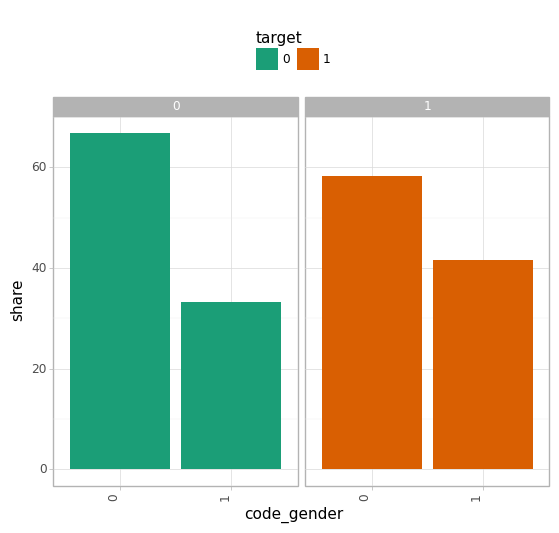

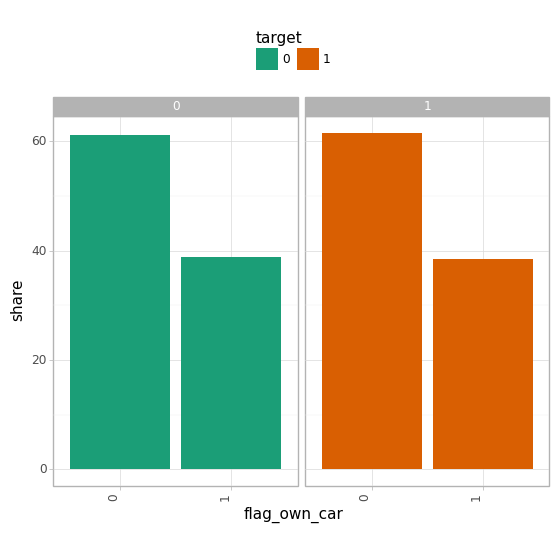

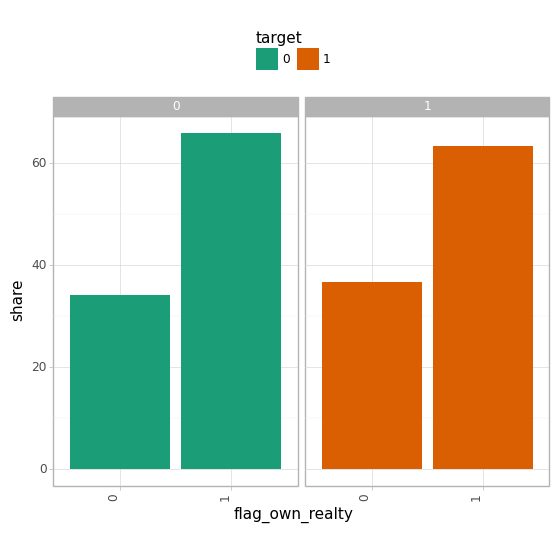

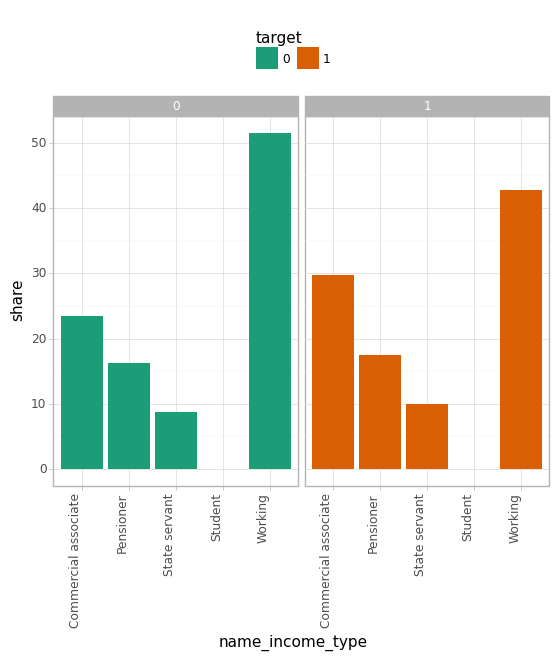

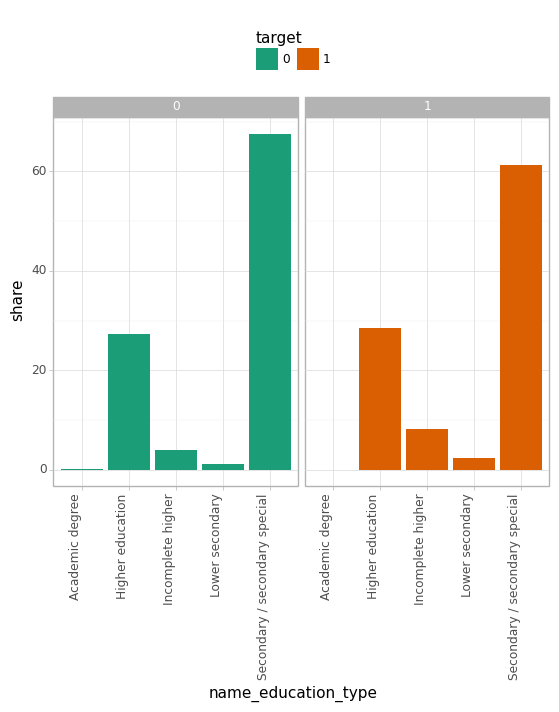

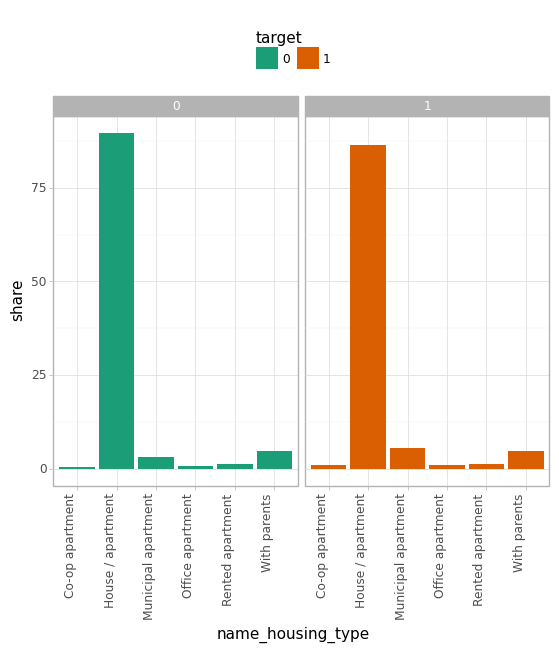

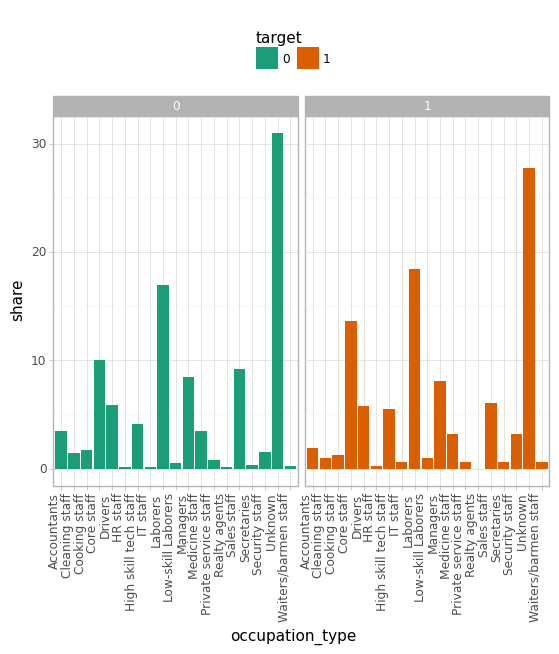

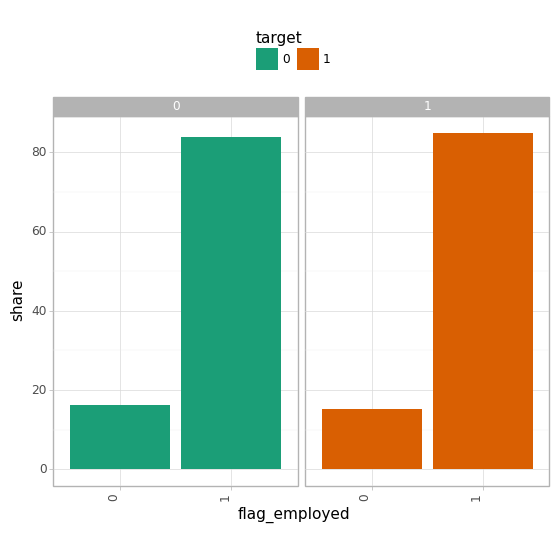

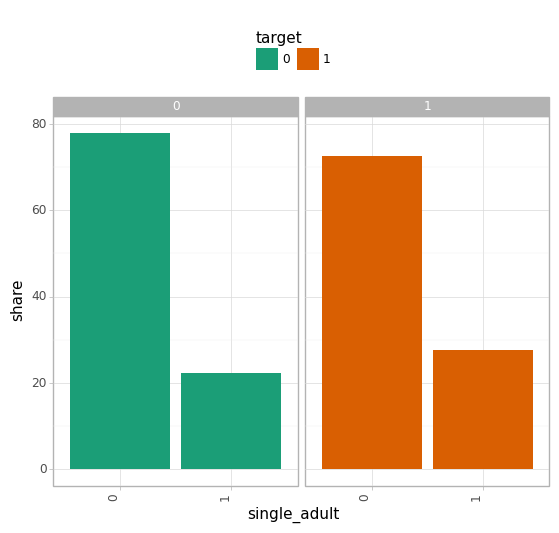

In [19]:
for var in cat_vars:
    plot_share_of_categorical_vars_by_target(df_merged, var, "target")

## Relationship between a binary and a continuous variable

### Point biserial correlation

In [20]:
df_merged.columns

Index(['code_gender', 'flag_own_car', 'flag_own_realty', 'amt_income_total',
       'name_income_type', 'name_education_type', 'name_housing_type',
       'occupation_type', 'amt_income_per_person', 'age', 'job_tenure',
       'flag_employed', 'single_adult', 'target'],
      dtype='object')

In [21]:
for var in num_vars:
    print(var)
    cor_pbs, p_value = pointbiserialr(df_merged['target'], df_merged[var])
    if p_value <= alpha:
        print('Correlation is signifincat (p-value: ' + str(round(p_value, 4)) + ').')
        print('Point biserial correlation equals ' + str(round(cor_pbs, 4)))
    else:
        print('Correlation is NOT signifincat (p-value: ' + str(round(p_value, 4)) + ').')
        print('Point biserial correlation equals ' + str(round(cor_pbs, 4)))

amt_income_total
Correlation is NOT signifincat (p-value: 0.1927).
Point biserial correlation equals 0.0092
amt_income_per_person
Correlation is signifincat (p-value: 0.0461).
Point biserial correlation equals 0.0141
age
Correlation is NOT signifincat (p-value: 0.1818).
Point biserial correlation equals -0.0094
job_tenure
Correlation is signifincat (p-value: 0.0328).
Point biserial correlation equals -0.0151


### Plots

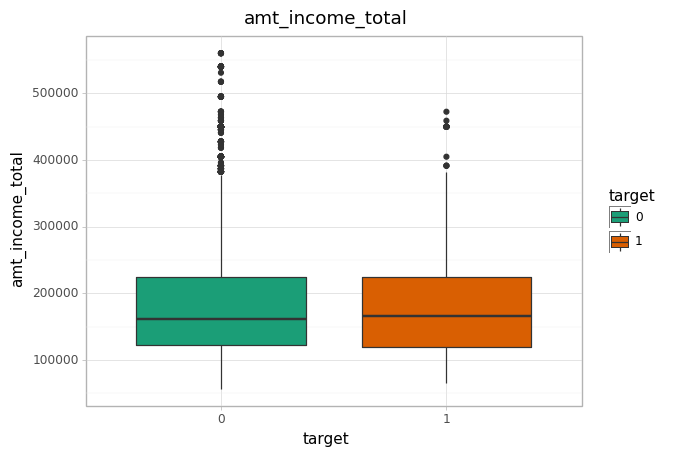

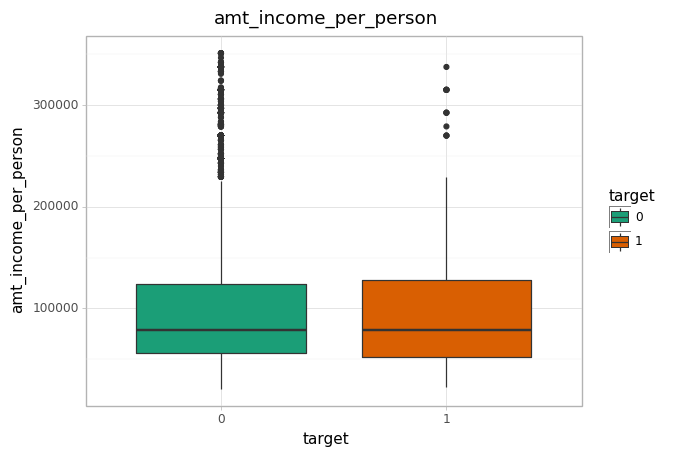

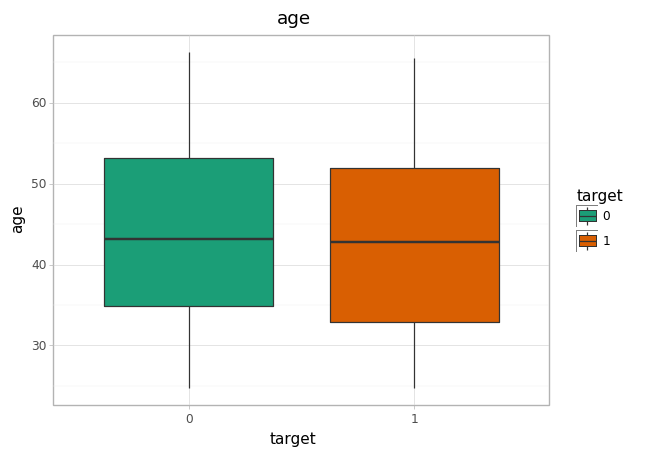

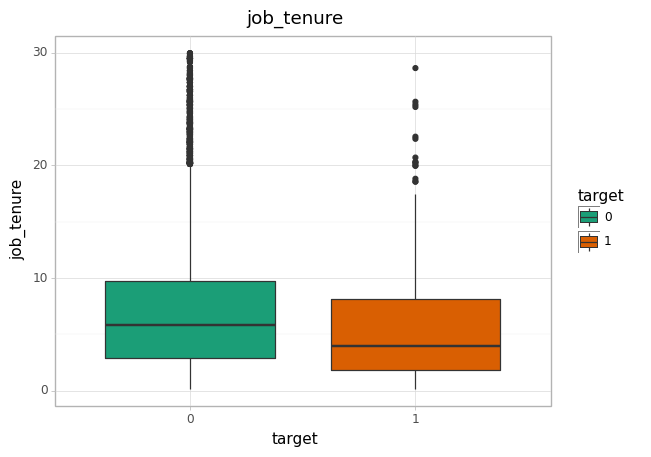

In [22]:
for var in num_vars:
    plot_boxplot_by_target(df_merged, var, "target", 0.01)

# Profiling report

In [23]:
pandas_profiling_post_feat_eng = ProfileReport(df_merged, title = "Report - pandas_profiling - post feature engineering")
pandas_profiling_post_feat_eng.to_file("reports/Report pandas-profiler - post feature engineering.html")
pandas_profiling_post_feat_eng.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]